## Identificação:

**Nome: Adriano Ulrich do Prado Wiedmann**

**Matrícula: 202014824**

In [1]:
#allows the drive to be accessed
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [43]:
import sys

!cat '/content/drive/MyDrive/DP7/utils_exp2.py'
sys.path.append('/content/drive/MyDrive/DP7/')

# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt

# Optimization module in scipy
from scipy import optimize

# Machine Learning Library
import torch

# work with math and erfc
import math
from scipy.special import erfc

from pylab import *
from sklearn.manifold import TSNE

# Função Q(x)
def func_q(x):
    return (1/2)*erfc((1/math.sqrt(2))*x)

# Detector ótimo para os esquemas tradicionais de modulação
def genareteBER(M, EbNodB_range):
    # gera o vetor de BER para cada uma das modulações tradicionais: M-ASK, M-PSK e M-QAM para 
    # uma dada lista de SNRs
    m_ask = [None]*len(EbNodB_range)
    m_psk = [None]*len(EbNodB_range)
    m_qam = [None]*len(EbNodB_range)
    for n in range(0,len(EbNodB_range)):
        EbNo=10.0**(EbNodB_range[n]/10.0)
        m_ask[n] = 2*(1-(1/M))*func_q((math.sqrt((6*math.log2(M))/(M**2-1)*EbNo)))
        m_psk[n] = 2*func_q(math.sin(math.pi/M)*math.sqrt(2*math.log2(M)*EbNo))
        

In [44]:
# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt
%matplotlib inline

# Optimization module in scipy
from scipy import optimize

# Machine Learning Library
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# work with math and erfc
import math
from scipy.special import erfc

# aditional modules for vizualisation
from pylab import *
from sklearn.manifold import TSNE

# complementary functions
import utils_exp2

In [45]:
train_on_gpu = torch.cuda.is_available() #Check if the GPU is available
if train_on_gpu: #if yes
    device = torch.device('cuda') #Select device as GPU
    print("Treinando na GPU.")
else: #Se não
    device = torch.device('cpu') #Select device as CPU
    print("GPU indisponível, treinando na CPU.")

Treinando na GPU.


In [46]:
# Definição da Classe Autoencoder
class autoencoder(nn.Module):
    def __init__(self,M, n_channel, n_simbolos):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(M, n_channel*n_simbolos),
            nn.ReLU(True),
            nn.Linear(n_channel*n_simbolos, n_channel*n_simbolos),
            nn.BatchNorm1d(n_channel*n_simbolos, affine=True))
        self.decoder = nn.Sequential(
            nn.Linear(n_channel*n_simbolos, M),
            nn.ReLU(True),
            nn.Linear(M, M),
            nn.Softmax())

    def forward(self, x, R, n_channel, n_simbolos, EbN0):
        outs = {}
        # Número de linhas de x
        x_size = x.shape[0]

        # Encoder Layer
        x = self.encoder(x)
        # Normalização Euclidiana
        x = nn.functional.normalize(x, p=2, dim=-1)
        x = x*math.sqrt(n_channel)
        # Saída do vetor de codificado e normalizado
        outs['encoded'] = x

        # Channel Influence
        # Cria-se o vetor de ruído
        noise_channel = torch.normal(0.0, math.sqrt(1/(2*R*(10.0**(EbN0/10.0)))),[x_size, n_channel*n_simbolos])
        # Influencia do Canal - Soma com o ruído
        x = x + noise_channel
        # Saída do vetor de com ruído
        outs['encoded_noise'] = x

        # Decoder Layer
        x = self.decoder(x)
        # Saída do vetor de decodificado
        outs['decoded'] = x
        return outs

    def auto_encoder(self, x, n_channel, n_simbolos):
        x = self.encoder(x)
        x = nn.functional.normalize(x, p=2, dim=-1)
        x = x*math.sqrt(n_channel)
        return x

    def auto_decoder(self, x):
        x = self.decoder(x)
        return x

In [47]:
# Parametros do modelo de Autoencoder
# Número de bits do sinal mensagem
k = 3 #Alterado de acordo com o pdf Parte 7 atualizado

# Número de usos do canal
n_channel = 1 #Alterado de acordo com o pdf Parte 7 atualizado

# Quantidade de mensagens possíveis
M = 2**k

# Taxa de bits por uso do canal
R = k/n_channel

# Relação sinal-ruído desejada para o treinamento
EbN0 = 7

# Transmisão de símbolos complexos (IQ)
#-- Para transmissão de símbolos reais basta fazer essa variável igual a 1
n_simbolos = 2

# Parametros da Rede
#n_net = n_simbolos*n_channel

In [48]:
# Criação do Autoencoder
model = autoencoder(M,n_channel, n_simbolos)

In [49]:
# Parametros de treinamento
# Taxa de aprendizado
learning_rate = 1e-3

# Quantidade de épocas de treinamento
num_epochs = 2000

# Tamanho do conjunto de cada treinamento - batch size
batch_size = 10*M

# Qunatidade de amostras de treinamento
N_treino = batch_size*10

In [50]:
# Montagem do dataset de treino
train_dataset = torch.eye(M)
data = train_dataset.repeat(int(N_treino/M),1)

In [51]:
# Treinamento do AE

# Função de perda do treinamento
criterion = nn.CrossEntropyLoss()

# Algortimo de otimização
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Para guardar os valores de loss
loss_epoch = []

for epoch in range(num_epochs):
    # Definição do dataset (aleatório para cada época)
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

    # Para cada batch size em 'dataloader'
    for input_in in dataloader:
        # ===================forward=====================
        # Codificação do sinal de entrada
        output = model(input_in,R,n_channel, n_simbolos,EbN0)
        # Formatação dos dados para comparação na função de custo
        target_crossEntropy = torch.argmax(input_in, dim=-1).type(torch.LongTensor)
        # Cross-Entropy Loss
        loss = criterion(output['decoded'], target_crossEntropy)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_epoch.append(loss.data)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.data))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


epoch [1/2000], loss:2.0891
epoch [2/2000], loss:2.0837
epoch [3/2000], loss:2.0754
epoch [4/2000], loss:2.0751
epoch [5/2000], loss:2.0619
epoch [6/2000], loss:2.0626
epoch [7/2000], loss:2.0551
epoch [8/2000], loss:2.0507
epoch [9/2000], loss:2.0412
epoch [10/2000], loss:2.0422
epoch [11/2000], loss:2.0397
epoch [12/2000], loss:2.0399
epoch [13/2000], loss:2.0264
epoch [14/2000], loss:2.0269
epoch [15/2000], loss:2.0180
epoch [16/2000], loss:2.0263
epoch [17/2000], loss:1.9980
epoch [18/2000], loss:2.0065
epoch [19/2000], loss:1.9896
epoch [20/2000], loss:2.0010
epoch [21/2000], loss:1.9668
epoch [22/2000], loss:1.9758
epoch [23/2000], loss:1.9531
epoch [24/2000], loss:1.9476
epoch [25/2000], loss:1.9520
epoch [26/2000], loss:1.9016
epoch [27/2000], loss:1.9408
epoch [28/2000], loss:1.9238
epoch [29/2000], loss:1.9626
epoch [30/2000], loss:1.8947
epoch [31/2000], loss:1.9047
epoch [32/2000], loss:1.9058
epoch [33/2000], loss:1.8993
epoch [34/2000], loss:1.8737
epoch [35/2000], loss:1

In [52]:
# Parametros do modelo de Autoencoder

# Paramêtros de Teste
N_teste = 100000*M
test_label = torch.randint(0, M, (N_teste,))
test_data = torch.nn.functional.one_hot(test_label).float()

# Variáveis de teste
EbNodB_range = torch.arange(0,8,0.5)
ber = [None]*len(EbNodB_range)

In [53]:
# Teste do modelo treinado e cálculo da BER
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo)).item()
    noise_mean = 0.0
    no_errors = 0
    noise = torch.normal(noise_mean, noise_std,[N_teste, n_channel*n_simbolos])

    # Embaralhamneto do dataset de teste
    data = TensorDataset(test_data, torch.LongTensor(test_label))
    dataloader_test = DataLoader(data, batch_size=N_teste, shuffle=True)

    # Dividindo o dataset em labels e dados
    test_data_ = dataloader_test.dataset.tensors[0]
    label_ = np.array(dataloader_test.dataset.tensors[1])

    # Codificação do sinal
    encoded_signal = model.auto_encoder(test_data_, n_channel, n_simbolos)

    # Influencia do Canal
    channel_signal = encoded_signal + noise

    # Decodificação do sinal
    pred_final_signal = model.auto_decoder(channel_signal)
    parse_pred_output = pred_final_signal.tolist()
    pred_output = np.argmax(parse_pred_output,axis=1)   #retorna um array com a posição de maior argumento

    # Calculo da BER
    no_errors = (pred_output != label_)
    no_errors =  no_errors.astype(int).sum()
    ber[n] = no_errors / N_teste
    print ('SNR:',EbNodB_range[n].item(),'BLER:',ber[n], 'no_errors:',no_errors)

SNR: 0.0 BLER: 0.349925 no_errors: 279940
SNR: 0.5 BLER: 0.32196625 no_errors: 257573
SNR: 1.0 BLER: 0.29455375 no_errors: 235643
SNR: 1.5 BLER: 0.2662475 no_errors: 212998
SNR: 2.0 BLER: 0.23946 no_errors: 191568
SNR: 2.5 BLER: 0.2131175 no_errors: 170494
SNR: 3.0 BLER: 0.18758875 no_errors: 150071
SNR: 3.5 BLER: 0.16410375 no_errors: 131283
SNR: 4.0 BLER: 0.13941875 no_errors: 111535
SNR: 4.5 BLER: 0.1176175 no_errors: 94094
SNR: 5.0 BLER: 0.0976275 no_errors: 78102
SNR: 5.5 BLER: 0.07936875 no_errors: 63495
SNR: 6.0 BLER: 0.063355 no_errors: 50684
SNR: 6.5 BLER: 0.04891375 no_errors: 39131
SNR: 7.0 BLER: 0.03735 no_errors: 29880
SNR: 7.5 BLER: 0.0277625 no_errors: 22210


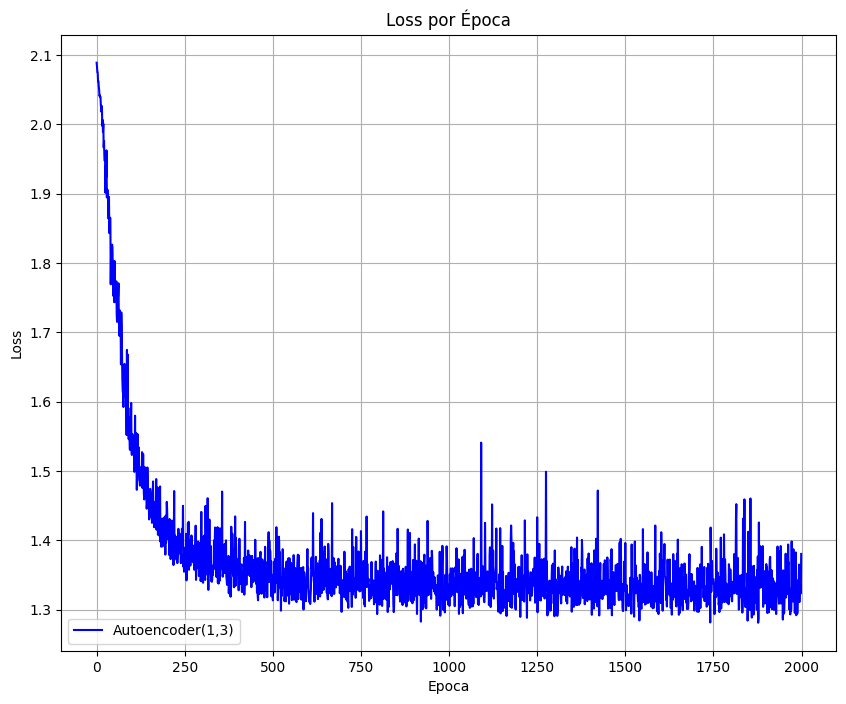

In [54]:
# Plot da curva de Loss
vector_loss = np.arange(0,len(loss_epoch),1)
fig = plt.figure(figsize=(10,8))
plt.plot(vector_loss,loss_epoch,'b',label='Autoencoder(%d,%d)'%(n_channel, k))
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.title('Loss por Época')
plt.legend(loc='lower left',ncol = 1)
plt.grid()
plt.show()

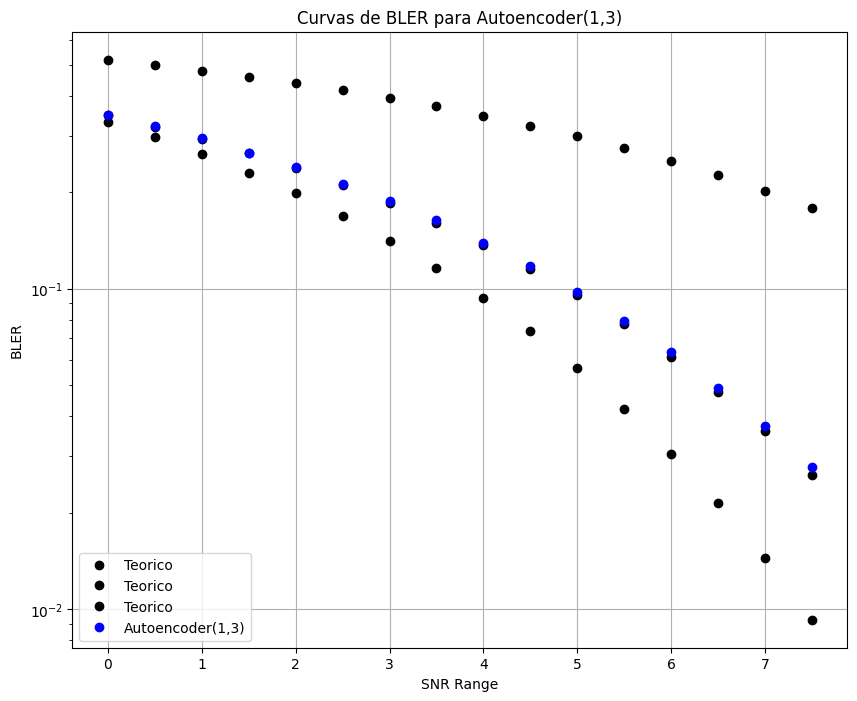

In [55]:
# Plot da curva de BER

# Curvas do detector ótimo
#-- Gera as curvas téoricas para as moduações ASK, PSK e QAM para um dado M e intervalos de SNR
ask_M, psk_M, qam_M = utils_exp2.genareteBER(2**k, EbNodB_range)

fig = plt.figure(figsize=(10,8))
fig_title = "Curvas de BLER para Autoencoder("+str(n_channel)+","+str(k)+")"
plt.plot(EbNodB_range, ask_M, 'ko',label='Teorico')
plt.plot(EbNodB_range, psk_M, 'ko',label='Teorico')
plt.plot(EbNodB_range, qam_M, 'ko',label='Teorico')
plt.plot(EbNodB_range, ber, 'bo', label='Autoencoder(%d,%d)'%(n_channel, k))
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('BLER')
plt.title(fig_title)
plt.grid()
plt.legend(loc='lower left',ncol = 1)
plt.show()

<Figure size 640x480 with 0 Axes>

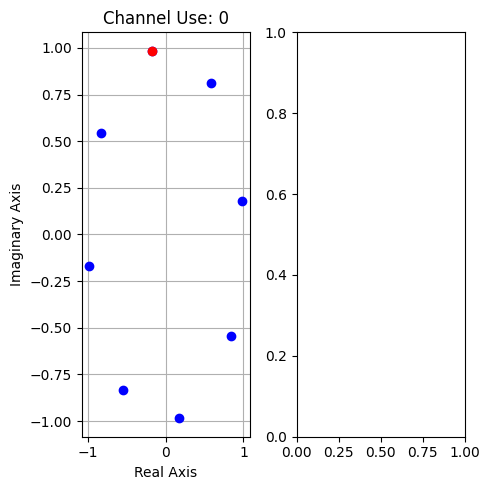

In [56]:
# Mensagens codigicadas pelo Encoder
data_encoded_symbol = model.auto_encoder(torch.eye(M),n_channel, n_simbolos)

# Separação dos símbolos em real e imaginário
real_symb, imag_symb = utils_exp2.split_symb(data_encoded_symbol)

# Plotagem das constelações por uso do canal
utils_exp2.plot_graphs(real_symb.detach().numpy(),imag_symb.detach().numpy(),n_channel,sizefig=5)